# Final Project: Pairs Trading Strategy: Design and Back test

## Introduction
Pairs Trading (and Stastical Arbitrage) is very popular class of strategies for several reasons. I think most importantly because it has both strong quantitative and fundamental background. Usually, by going through a certain statitical procedure the trader may have construct a long/short portfolio that exhibits a mean reversive behavior. And under certain conditions, strategy based on systematic mean reversive signal would be the closest thing to the holy grail of trading. No surprise that exploring mean reversive signals is the first thing that prospective quant traders learn to do. Both academic literature and online blogs are full with detailed instructions on constructing stat arb portfolio. With wide availability of free financial data, statistical packages and lowering cost of trading stock market, I believe the alpha of trading pairs on developed market equities and ETFs may still exist but the Sharpe ratio is probably materially lower than decade ago.

In this project I will try to research pairs trading signals on one of the markets that considered to be "alternative", otc foreign exchange volatility market. The motivation behind this choice is that the strategy would not be as crowded because significantly fewer quantitative traders have access to this market and even for them back testing and trading are both much more messy comparing to equities. Moreover, from my observation fundamental reason why the strategy works is especially strong for this market. Before we introduce any math, we can have the intuiton that volitilties of most traded currencies react similarly to the same global factors and especially if these currencies of countries with same geography, similar economy structure or close in some other way. Apart from global impact, there are of course idiosyncratic factors driven by local fundamentals or difference in liquidity. My fundamental reason to see strong potential for pairs traiding based on panel of fx volatiilites is that macro of deloped countries tend to synchronise. But most importantly I think there is a technical (or based on market structure) reason to believe in the strategy: trading long/short pairs of volatilities will be de-facto one-sided liquidity provision to the market when large order disturbs the vols in one of the currencies. If we really simplify, fx volatilites market mainly consists of customers who directionally trade fx option for hedging or speculating reasons and liquidity providers (usually large banks) who quote for the custmers but run delta neutral book. Over past decades various regulators have made a lot customers hedge their fx risks and at the same time banks' mandates and risk limites became more strict. In such situtation liquidity from prime market LPs may have not be enough to sustein implied volailities closed the "fair" levels and some other market participants have to step in. Relative value volatility traders is one group of such participants (obviously not the only one). By indetifying rich and cheap volatilites they help facilitating customers' flow perhapse even without directly dealing with customers.

I hope I have managed to explain the motivation behind my choice of project and the market. Now I should say a little about how exactly I am planning to conduct a research. I obtained a data set which is a panel at-the-money implied volatilites of eight currency pairs in 1 year tenor. I should note that for the purpose of such research variance swaps or FVAs should work better as they provide pure vol exposure rather than contaminated by gamma and skew effects. However those instruments are considered exotic hence more problems with market data and execution. My plan is first to apply statistical methods (Engle-Granger and Johansen) to subsets of the panel. This will give me a number of candidate strategies and by applying economic (or may call it common sense) filter to these strategies I will come up with final strategy for ready for "back test". I am putting back test in quotes because it is not a true back test. True options strategy back test is a real pain because we have to deal with delta hedging, skew, bleed, rollover and vega rebalancing. My peronal opinion is that building a toll for fx options back testing is bigger project than building a statistical arbitrage portfolio. In this case I am going to asssume that 1y atm is actually tradable index and put the above mentioned effects aside. I believe this is not criminal for two reasons: first, I want to see if the strategy really performs in my simplified back test because otherwise there is no reason even to try true back testing, second, since we going to work with market neutral l/s portfolios most of those effects are going to be canceled out (admittedly, introducing some noise).

## Brief Math overview

--- Insert here brief summay on ADF, Engle-Granger, Johansen, Ornestein Ulenbeck etc ---

--- Inset here explanation of classes and procedures from attached CointTests.py ---

Below examples and explanation of the above methods and code

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats import t
import cufflinks as cf
from math import log, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import datetime as dt

from CointTests import *

In [2]:
#Importing and exploring the data
df1y = pd.read_excel('G10V1Y.xlsx', parse_dates = ['Dates'], index_col='Dates')
df1y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6413 entries, 1999-01-01 to 2023-08-01
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURUSD  6410 non-null   float64
 1   USDJPY  6409 non-null   float64
 2   GBPUSD  6402 non-null   float64
 3   USDCHF  6371 non-null   float64
 4   USDCAD  5842 non-null   float64
 5   AUDUSD  6407 non-null   float64
 6   NZDUSD  6173 non-null   float64
dtypes: float64(7)
memory usage: 400.8 KB


In [3]:
#Imputing the previous value when missed and droping the tail
df1y_clean = df1y.ffill().dropna()
df1y_clean.iplot() #TODO format chart

Nicely looking chart above. I think I can see some mean reversion. May be we don't need pairs at all? But if we take a look closely at shorter horizon, situation is not so great.

In [4]:
#TODO format output and charts
idx = pd.bdate_range(end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-3))
print("Critial value for all the below on 95% signicance level = ", tableADF(len(idx),0)[1])
for c in df1y.columns:
    price_series = df1y_clean.loc[idx, c]
    #p_value = ts.adfuller(price_series, regression='c', autolag=None, maxlag=1)[1]
    adf = AugmentedDickeyFuller(price_series, autolag=None, maxlag=1)
    adf.fit()
    adf_stat = adf.coeff
    print("ADF test stat for ", c," = ", adf_stat)
    #print (c, p_value)
    price_series.iplot()

Critial value for all the below on 95% signicance level =  -2.87104
ADF test stat for  EURUSD  =  -1.5907660144764717


ADF test stat for  USDJPY  =  -1.2429783007123856


ADF test stat for  GBPUSD  =  -2.048059067432825


ADF test stat for  USDCHF  =  -1.6275167578242993


ADF test stat for  USDCAD  =  -2.402559496575519


ADF test stat for  AUDUSD  =  -1.7022389976820849


ADF test stat for  NZDUSD  =  -1.7849877141690795


Below is the example of testing cointegraion of spread using Engle-Granger procedure

In [5]:
idx = pd.bdate_range(end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-3))
s1 = df1y_clean.loc[idx, 'EURUSD']
s2 = df1y_clean.loc[idx, 'GBPUSD']
EG = EngleGranger(s1, s2)
EG.fit()
adf_critical = tableADF(len(idx), 0)[1]
st_critical = t.ppf(0.05, len(idx)-2)
spread = (s1 - EG.coeff[1] * s2)
AR_regression = LinearRegression(spread[:-1], spread[1:])
AR_regression.fit()
theta = 1 - float(AR_regression.coeff[1])
hl  = log(2) / theta
print(EG)
print("5% signicance Critical Value for ADF test:", adf_critical)
print("5% significance Critical Value for ECM coefficient:", st_critical)
spread.iplot()
print("Half-Life:", hl)

Engle-Granger Cointegration Test
--------------------------------
Beta from naive regression: 0.7837153537654302
ADF Statistic for residuals: -2.944280892717286
ECM Coefficient: -0.011378793250154994
ECM t-statistic: -1.6665564409631346

5% signicance Critical Value for ADF test: -2.87104
5% significance Critical Value for ECM coefficient: -1.6468095135377019


Half-Life: 31.507502942208944


We can apply same procedure to all possible spreads to find all cointegrating pairs

In [6]:
idx = pd.bdate_range(end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-3))
pairs = df1y.columns
cointegrated_portfolios = []
adf_critical = tableADF(len(idx), 0)[1]
st_critical = t.ppf(0.05, len(idx)-2)
for i, c1 in enumerate(pairs):
    for c2 in pairs[i+1:]:
        EG1 = EngleGranger(df1y_clean.loc[idx, c1], df1y_clean.loc[idx, c2])
        EG1.fit()
        EG2 = EngleGranger(df1y_clean.loc[idx, c2], df1y_clean.loc[idx, c1])
        EG2.fit()
        EG = None
        if (EG1.ADFstat < adf_critical) and (EG1.ecm_tstat < st_critical):
            if (EG2.ADFstat < adf_critical) and (EG2.ecm_tstat < EG1.ecm_tstat):
                EG = EG2
                portfolio = (c2, c1)
            else:
                EG = EG1
                portfolio = (c1, c2)
        elif (EG2.ADFstat < adf_critical) and (EG2.ecm_tstat < st_critical):
            EG = EG2
            portfolio = (c2, c1)
        if EG != None:
            res = np.array(EG.residuals).reshape(-1, 1)
            AR_regression = LinearRegression(res[:-1], res[1:], add_constant=False)
            AR_regression.fit()
            theta = 1 - float(AR_regression.coeff[0])
            hl  = log(2) / theta
            cointegrated_portfolios.append([portfolio, [1, -EG.coeff[1]], hl, EG.coeff[0], EG.residuals.std()])
strategies = pd.DataFrame(cointegrated_portfolios, columns=['Portfolio', 'Weights', 'Half-Life', 'Mean', 'Std'])
strategies

Portfolio                    Weights  Half-Life      Mean       Std
0   (GBPUSD, EURUSD)   [1, -1.0490068799428753]  29.697088  1.355949  0.675689
1   (USDCAD, EURUSD)  [1, -0.47915163362853785]  28.767705  3.704089  0.398740
2   (AUDUSD, EURUSD)   [1, -0.9298863979232265]  18.121404  3.887087  0.454759
3   (NZDUSD, EURUSD)   [1, -0.8888563067694132]  20.359095  4.283320  0.478518
4   (USDCHF, USDJPY)   [1, -0.5261046050690216]  21.485939  2.943304  0.370240
5   (AUDUSD, USDJPY)   [1, -0.6558739349356975]  30.312746  5.139597  0.571119
6   (AUDUSD, GBPUSD)   [1, -0.7591677695191336]  28.108402  3.832608  0.621000
7   (NZDUSD, GBPUSD)   [1, -0.7377915010211566]  25.895116  4.121964  0.588940
8   (AUDUSD, USDCHF)   [1, -1.2367176815370375]  13.280978  1.543726  0.375456
9   (NZDUSD, USDCHF)   [1, -1.1871323031990246]  14.928217  2.006555  0.394353
10  (NZDUSD, AUDUSD)   [1, -0.9642292315864096]   6.819687  0.478561  0.100549

To be able to construct integrating portfolios of more than two assets we can use Johansen procedure, example below

In [7]:
idx = pd.bdate_range(end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-3))
demo_df = df1y_clean.loc[idx]
demo_df.to_csv('sample.csv')
res = coint_johansen(demo_df, det_order=1, k_ar_diff=1)
print("Currencies:", np.array(demo_df.columns))
print("Time period:", demo_df.index[0], "to ", demo_df.index[-1])
with np.printoptions(precision=4, suppress=True, linewidth=100, threshold=10000):
    print("Eigenvalues:\n", res.eig)
    print("Eigevectors normilized to first column")
    print((res.evec/res.evec[0,:]))
    print("Test statistics for eigevalues test: \n", res.lr2)
    print("Critical values for eigenvalues test: \n", res.cvm)
    print("Test statistics for trace test: \n", res.lr1)
    print("Critical values for trace test: \n", res.cvt)

Currencies: ['EURUSD' 'USDJPY' 'GBPUSD' 'USDCHF' 'USDCAD' 'AUDUSD' 'NZDUSD']
Time period: 2020-08-03 00:00:00 to  2023-08-01 00:00:00
Eigenvalues:
 [0.0866 0.0649 0.0443 0.0252 0.0208 0.0107 0.0038]
Eigevectors normilized to first column
[[ 1.      1.      1.      1.      1.      1.      1.    ]
 [ 0.0202 -3.43    2.5834 -0.143   0.35   -0.6053  0.546 ]
 [-0.4456  0.1934 -0.9392  0.5599 -0.3522 -0.5053 -0.0348]
 [-0.5242 -2.0188 -6.9254 -1.7382 -0.8935 -0.4097 -0.9659]
 [-0.8533 -5.066   1.8173 -0.0784 -0.1609  0.8571 -0.4142]
 [-3.3825 10.654  -1.3359 -0.3075  2.6343 -0.3816  2.0392]
 [ 3.8922 -4.3847  2.8762 -0.0299 -3.0803  0.4514 -1.0512]]
Test statistics for eigevalues test: 
 [70.6926 52.3034 35.3674 19.9316 16.3988  8.3634  2.9623]
Critical values for eigenvalues test: 
 [[46.5583 49.5875 55.8171]
 [40.5244 43.4183 49.4095]
 [34.4202 37.1646 42.8612]
 [28.2398 30.8151 36.193 ]
 [21.8731 24.2522 29.2631]
 [15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]
Test statistics for t

For the purposes of validation below is the output of same Johansen procedure realised in urca package in R (notebook attached)

In [ ]:
"""
###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend in cointegration 

Eigenvalues (lambda):
[1] 8.681531e-02 6.491141e-02 4.498019e-02 2.524265e-02 2.093684e-02
[6] 1.115009e-02 3.838508e-03 1.058603e-19

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 6 |  3.00 10.49 12.25 16.26
r <= 5 |  8.75 16.85 18.96 23.65
r <= 4 | 16.50 23.11 25.54 30.34
r <= 3 | 19.94 29.12 31.46 36.65
r <= 2 | 35.90 34.75 37.52 42.36
r <= 1 | 52.35 40.91 43.97 49.51
r = 0  | 70.84 46.32 49.42 54.71

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1     USDCAD.l1
EURUSD.l1  1.0000000000  1.000000000  1.000000000  1.000000000  1.0000000000
USDJPY.l1  0.0207768779 -3.308560787  2.529184122 -0.133789585  0.3862586788
GBPUSD.l1 -0.4452429768  0.168826928 -0.944150839  0.554988453 -0.3649242158
USDCHF.l1 -0.5168014916 -2.016251559 -6.701254951 -1.749746487 -0.9406498998
USDCAD.l1 -0.8529661238 -4.917172821  1.787756635 -0.076789693 -0.1610919147
AUDUSD.l1 -3.3933295094 10.227332608 -1.646689862 -0.277973496  2.7530897365
NZDUSD.l1  3.8967157329 -4.123881048  3.118771307 -0.057159865 -3.1948383164
trend.l1  -0.0009139176  0.008054423 -0.002876728  0.002882231 -0.0006208891
             AUDUSD.l1    NZDUSD.l1    trend.l1
EURUSD.l1  1.000000000  1.000000000  1.00000000
USDJPY.l1 -0.584194188  0.599061522 -0.12121190
GBPUSD.l1 -0.477917502  0.009137399 -1.00067511
USDCHF.l1 -0.341291927 -0.896297870 -3.66759988
USDCAD.l1  0.758080316 -0.562074994  3.14676486
AUDUSD.l1 -0.332166724  2.130305915  1.55032367
NZDUSD.l1  0.350012538 -1.159317619  0.60478400
trend.l1   0.002779736 -0.006260931 -0.03102493

Weights W:
(This is the loading matrix)

            EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1   USDCAD.l1
EURUSD.d -0.024815011 -0.001814062  0.004801192 -0.007149011 0.016272311
USDJPY.d -0.017587072  0.005780029 -0.005553754  0.013455230 0.007856729
GBPUSD.d  0.049180103 -0.008215842  0.003300531 -0.015434050 0.028860202
USDCHF.d -0.007355715 -0.001165697  0.007172014  0.008912249 0.012091008
USDCAD.d  0.033490474 -0.004382338 -0.004305310  0.006654707 0.015691150
AUDUSD.d -0.004061438 -0.016636403 -0.002835407  0.010884921 0.009490065
NZDUSD.d -0.028707090 -0.014768301 -0.003930218  0.012517206 0.015111040
             AUDUSD.l1    NZDUSD.l1      trend.l1
EURUSD.d -0.0011319541 -0.003675070 -1.746001e-16
USDJPY.d  0.0127064706 -0.003730429 -2.571902e-16
GBPUSD.d  0.0111150365 -0.002067616  3.587586e-16
USDCHF.d  0.0006710432 -0.002411493 -3.654559e-17
USDCAD.d -0.0025956171 -0.002483430  2.418684e-16
AUDUSD.d  0.0030976156 -0.003101983  2.922343e-16
NZDUSD.d  0.0027200313 -0.002436642  6.585911e-17


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend in cointegration 

Eigenvalues (lambda):
[1] 8.681531e-02 6.491141e-02 4.498019e-02 2.524265e-02 2.093684e-02
[6] 1.115009e-02 3.838508e-03 1.058603e-19

Values of teststatistic and critical values of test:

           test  10pct   5pct   1pct
r <= 6 |   3.00  10.49  12.25  16.26
r <= 5 |  11.75  22.76  25.32  30.45
r <= 4 |  28.25  39.06  42.44  48.45
r <= 3 |  48.19  59.14  62.99  70.05
r <= 2 |  84.09  83.20  87.31  96.58
r <= 1 | 136.44 110.42 114.90 124.75
r = 0  | 207.28 141.01 146.76 158.49

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1     USDCAD.l1
EURUSD.l1  1.0000000000  1.000000000  1.000000000  1.000000000  1.0000000000
USDJPY.l1  0.0207768779 -3.308560787  2.529184122 -0.133789585  0.3862586788
GBPUSD.l1 -0.4452429768  0.168826928 -0.944150839  0.554988453 -0.3649242158
USDCHF.l1 -0.5168014916 -2.016251559 -6.701254951 -1.749746487 -0.9406498998
USDCAD.l1 -0.8529661238 -4.917172821  1.787756635 -0.076789693 -0.1610919147
AUDUSD.l1 -3.3933295094 10.227332608 -1.646689862 -0.277973496  2.7530897365
NZDUSD.l1  3.8967157329 -4.123881048  3.118771307 -0.057159865 -3.1948383164
trend.l1  -0.0009139176  0.008054423 -0.002876728  0.002882231 -0.0006208891
             AUDUSD.l1    NZDUSD.l1    trend.l1
EURUSD.l1  1.000000000  1.000000000  1.00000000
USDJPY.l1 -0.584194188  0.599061522 -0.12121190
GBPUSD.l1 -0.477917502  0.009137399 -1.00067511
USDCHF.l1 -0.341291927 -0.896297870 -3.66759988
USDCAD.l1  0.758080316 -0.562074994  3.14676486
AUDUSD.l1 -0.332166724  2.130305915  1.55032367
NZDUSD.l1  0.350012538 -1.159317619  0.60478400
trend.l1   0.002779736 -0.006260931 -0.03102493

Weights W:
(This is the loading matrix)

            EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1   USDCAD.l1
EURUSD.d -0.024815011 -0.001814062  0.004801192 -0.007149011 0.016272311
USDJPY.d -0.017587072  0.005780029 -0.005553754  0.013455230 0.007856729
GBPUSD.d  0.049180103 -0.008215842  0.003300531 -0.015434050 0.028860202
USDCHF.d -0.007355715 -0.001165697  0.007172014  0.008912249 0.012091008
USDCAD.d  0.033490474 -0.004382338 -0.004305310  0.006654707 0.015691150
AUDUSD.d -0.004061438 -0.016636403 -0.002835407  0.010884921 0.009490065
NZDUSD.d -0.028707090 -0.014768301 -0.003930218  0.012517206 0.015111040
             AUDUSD.l1    NZDUSD.l1      trend.l1
EURUSD.d -0.0011319541 -0.003675070 -1.746001e-16
USDJPY.d  0.0127064706 -0.003730429 -2.571902e-16
GBPUSD.d  0.0111150365 -0.002067616  3.587586e-16
USDCHF.d  0.0006710432 -0.002411493 -3.654559e-17
USDCAD.d -0.0025956171 -0.002483430  2.418684e-16
AUDUSD.d  0.0030976156 -0.003101983  2.922343e-16
NZDUSD.d  0.0027200313 -0.002436642  6.585911e-17

"""

We can see that test statistics and eigenvectors are very close but there is some mismatch between critical value. There is online discussion about it. I understand python numbers also match Matlab. So I will go with it for now.

Here is an example of identifying cointegrating triplets with Johansen method:

In [8]:
idx = pd.bdate_range(end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-3))
pairs = df1y.columns
cointegrated_portfolios = []
for i, c1 in enumerate(pairs):
    for j, c2 in enumerate(pairs[i+1:]):
        for c3 in pairs[i+j+2:]:
            data = df1y_clean.loc[idx, [c1, c2, c3]] 
            res = coint_johansen(data, det_order=1, k_ar_diff=1)
            for d in range(3):
                if (res.lr2[d] > res.cvm[d, 1]) and (res.lr1[d] > res.cvt[d, 1]):
                    vec_norm = res.evec[:, d] / res.evec[0, d]
                    portfolio_value = np.array(data.dot(vec_norm)).reshape(-1, 1)
                    AR_regression = LinearRegression(portfolio_value[:-1], portfolio_value[1:])
                    AR_regression.fit()
                    theta = 1 - float(AR_regression.coeff[1])
                    hl  = log(2) / theta
                    cointegrated_portfolios.append([(c1, c2, c3), vec_norm, hl, portfolio_value.mean(), portfolio_value.std()])
                else:
                    break
strategies = pd.DataFrame(cointegrated_portfolios, columns=['Portfolio', 'Weights', 'Half-Life', 'Mean', 'Std'])
strategies           

Portfolio                                          Weights  \
0   (EURUSD, USDJPY, USDCHF)   [1.0, 0.6288391179711539, -2.4436136162828004]   
1   (EURUSD, USDJPY, USDCAD)  [1.0, -0.5430400303300689, -0.9301743174893118]   
2   (EURUSD, USDCHF, AUDUSD)    [1.0, -5.555300679687858, 2.8876449108531244]   
3   (EURUSD, USDCHF, NZDUSD)   [1.0, -3.8308992688384262, 1.7306773503948478]   
4   (EURUSD, USDCAD, AUDUSD)   [1.0, -0.2818964040218316, -0.933646033010308]   
5   (EURUSD, USDCAD, AUDUSD)    [1.0, 16.76726377784305, -10.477686232708638]   
6   (EURUSD, AUDUSD, NZDUSD)     [1.0, -5.730414157957027, 4.897527511334127]   
7   (EURUSD, AUDUSD, NZDUSD)     [1.0, 2.828048448026947, -4.110495942099535]   
8   (USDJPY, USDCHF, USDCAD)    [1.0, -2.306033469539366, 1.1074127045473412]   
9   (USDJPY, USDCHF, AUDUSD)     [1.0, -9.067042026549956, 5.419444558031873]   
10  (USDJPY, USDCHF, NZDUSD)     [1.0, -5.058811610874959, 2.674666094913599]   
11  (USDJPY, USDCAD, AUDUSD)    [1.0, 1.5723318457134523, -1.897522852269525]   
12  (USDJPY, USDCAD, NZDUSD)   [1.0, 1.8712242462196031, -2.1513172461271464]   
13  (USDJPY, AUDUSD, NZDUSD)      [1.0, -7.57663755954478, 6.857125351286302]   
14  (GBPUSD, USDCHF, AUDUSD)     [1.0, 419.1251576141922, -296.6450707879269]   
15  (GBPUSD, USDCHF, NZDUSD)    [1.0, 19.000318608815924, -15.15793201784787]   
16  (GBPUSD, USDCAD, NZDUSD)     [1.0, 1.994339389474501, -2.517105654145416]   
17  (GBPUSD, AUDUSD, NZDUSD)    [1.0, 8.791413680974047, -10.460126475219733]   
18  (USDCHF, USDCAD, AUDUSD)  [1.0, 0.20009968637997308, -0.8329434323700101]   
19  (USDCHF, USDCAD, AUDUSD)    [1.0, -5.143156474789645, 2.0937446750669624]   
20  (USDCHF, USDCAD, NZDUSD)   [1.0, 0.3455293662086203, -0.9495704189037442]   
21  (USDCHF, AUDUSD, NZDUSD)   [1.0, -2.3013424625290884, 1.6663221236164438]   
22  (USDCHF, AUDUSD, NZDUSD)     [1.0, 5.361962473451715, -6.364638378038371]   

    Half-Life       Mean         Std  
0   13.721192  -5.435279    0.455081  
1   21.992651  -3.982767    0.525487  
2   17.881008  -2.893183    1.444893  
3   21.170184  -2.344005    0.992831  
4   18.100178  -4.697107    0.477824  
5   36.689806  16.202713    6.670256  
6    6.085436  -1.117575    0.560249  
7   15.979386  -6.788045    0.751747  
8   10.882353  -0.611002    0.579759  
9   12.077678  -0.654768    2.305628  
10  12.267786  -0.101122    1.291766  
11  11.033428  -0.491853    0.587698  
12  10.267780  -1.256652    0.625985  
13  11.398487   1.423238    1.028671  
14  14.777809 -62.983049  124.700556  
15  15.136533 -13.971154    6.181914  
16  26.762502  -3.737918    1.174830  
17   8.364866  -9.812019    1.200429  
18  11.741071  -0.066963    0.284204  
19  44.287143  -7.305076    2.074015  
20  12.121724  -0.356453    0.314734  
21   8.894210   0.766014    0.313479  
22   9.220983  -3.935530    0.756403

## Constructing Trading Strategy

Based 

In [9]:
idx = pd.bdate_range(end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-10))
myPCA = PCA()
myPCA.fit(df1y_clean)#.loc[idx])
myPCA.explained_variance_ratio_[:3]
principal_components = pd.DataFrame(columns=list(range(1,4,1)), index=df1y.columns, data=myPCA.components_[:3].T)
principal_components.iplot(kind='bar')

In [10]:
myPCA = PCA(n_components=2)
myPCA.fit(df1y_clean)
residuals = (df1y_clean - myPCA.inverse_transform(myPCA.fit_transform(df1y_clean)))
for c in df1y.columns:
    price_series = residuals[c]
    p_value = ts.adfuller(price_series, regression='c', autolag=None, maxlag=1)[1]
    AR_regression = LinearRegression(price_series[:-1], price_series[1:])
    AR_regression.fit()
    theta = 1 - float(AR_regression.coeff[1])
    hl  = log(2) / theta
    print (c, p_value, hl, price_series.std())
    price_series.iplot()

EURUSD 3.769217080004343e-09 46.84334331082141 0.5725733576820192


USDJPY 4.906410299267366e-07 81.66021991095724 1.1508711266809135


GBPUSD 9.327652126800744e-07 69.07841929164803 0.8983022340464503


USDCHF 7.742391039266341e-08 49.98706331280737 0.6430042501860628


USDCAD 2.7044724240397826e-06 67.75211875747031 0.7529345522588846


AUDUSD 3.8688744003723506e-07 48.745790445470234 0.5503722442452622


NZDUSD 2.9103829071384675e-09 35.96666806987754 0.6612422337215514


It looks tradable (at least in-sample) although there are still problems ---add here---

Now we will build a systematic strategy based on Engle-Granger and Johansen and calculate performance --add here--

below procedures to pick cointegrated portfolios

In [11]:
def get_pairs_EG(df):
    cointegrated_portfolios = []
    adf_critical = tableADF(len(df), 0)[1]
    st_critical = t.ppf(0.05, len(df)-2)
    pairs = df.columns
    for i, c1 in enumerate(pairs):
        for c2 in pairs[i+1:]:
            EG1 = EngleGranger(df[c1], df[c2])
            EG1.fit()
            EG2 = EngleGranger(df[c2], df[c1])
            EG2.fit()
            EG = None
            if (EG1.ADFstat < adf_critical) and (EG1.ecm_tstat < st_critical):
                if (EG2.ADFstat < adf_critical) and (EG2.ecm_tstat < EG1.ecm_tstat):
                    EG = EG2
                    portfolio = (c2, c1)
                else:
                    EG = EG1
                    portfolio = (c1, c2)
            elif (EG2.ADFstat < adf_critical) and (EG2.ecm_tstat < st_critical):
                EG = EG2
                portfolio = (c2, c1)
            if EG != None:
                res = np.array(EG.residuals).reshape(-1, 1)
                AR_regression = LinearRegression(res[:-1], res[1:], add_constant=False)
                AR_regression.fit()
                theta = 1 - float(AR_regression.coeff[0])
                hl  = log(2) / theta
                norm = sum(np.abs([1, -EG.coeff[1]]))
                cointegrated_portfolios.append([list(portfolio), [1, -EG.coeff[1]] / norm, hl, EG.coeff[0] / norm, EG.residuals.std() / norm])

    return pd.DataFrame(cointegrated_portfolios, columns=['Portfolio', 'Weights', 'Half-Life', 'Mean', 'Std'])

def get_triplets_J(df):
    cointegrated_portfolios = []
    pairs = df.columns
    for i, c1 in enumerate(pairs):
        for j, c2 in enumerate(pairs[i+1:]):
            for c3 in pairs[i+j+2:]:
                data = df[[c1, c2, c3]]
                res = coint_johansen(data, det_order=1, k_ar_diff=1)
                for d in range(3):
                    if (res.lr2[d] > res.cvm[d, 1]) and (res.lr1[d] > res.cvt[d, 1]):
                        norm = sum(abs(res.evec[:, d]))
                        vec_norm = res.evec[:, d] / norm
                        portfolio_value = np.array(data.dot(vec_norm)).reshape(-1, 1)
                        AR_regression = LinearRegression(portfolio_value[:-1], portfolio_value[1:])
                        AR_regression.fit()
                        theta = 1 - float(AR_regression.coeff[1])
                        hl  = log(2) / theta
                        cointegrated_portfolios.append([[c1, c2, c3], list(vec_norm), hl, portfolio_value.mean(), portfolio_value.std()])
                    else:
                        break
    return pd.DataFrame(cointegrated_portfolios, columns=['Portfolio', 'Weights', 'Half-Life', 'Mean', 'Std'])

def get_quadruplets_J(df):
    cointegrated_portfolios = []
    pairs = df.columns
    for i, c1 in enumerate(pairs):
        for j, c2 in enumerate(pairs[i+1:]):
            for k, c3 in enumerate(pairs[i+j+2:]):
                for c4 in pairs[i+j+k+3:]:
                    data = df[[c1, c2, c3, c4]] 
                    res = coint_johansen(data, det_order=1, k_ar_diff=1)
                    for d in range(3):
                        if (res.lr2[d] > res.cvm[d, 1]) and (res.lr1[d] > res.cvt[d, 1]):
                            norm = sum(abs(res.evec[:, d]))
                            vec_norm = res.evec[:, d] / norm
                            portfolio_value = np.array(data.dot(vec_norm)).reshape(-1, 1)
                            AR_regression = LinearRegression(portfolio_value[:-1], portfolio_value[1:])
                            AR_regression.fit()
                            theta = 1 - float(AR_regression.coeff[1])
                            hl  = log(2) / theta
                            cointegrated_portfolios.append([[c1, c2, c3, c4], vec_norm, hl, portfolio_value.mean(), portfolio_value.std()])
                        else:
                            break
    return pd.DataFrame(cointegrated_portfolios, columns=['Portfolio', 'Weights', 'Half-Life', 'Mean', 'Std'])

Apart from cointegraton we want to filter out some portfolios (too high hl, too low std dev etc) 

--more here---

In [12]:
def select_strategies(strategies, min_weight=0.1, max_gross_weight=10, max_hl=60, min_std=0.3):
    strategies = strategies[strategies['Std'] > min_std]
    strategies = strategies[strategies['Half-Life'] < max_hl]
    for i in strategies.index:
        w = strategies.loc[i, 'Weights']
        if sum(np.abs(w)) > max_gross_weight:
            strategies = strategies.drop(i)
        elif min(np.abs(w)) < min_weight:
            strategies = strategies.drop(i)
    return strategies

def calculate_value_series(strategies, market_data):
    value_series = pd.DataFrame(index=market_data.index, columns=strategies.index)
    for i in strategies.index:
        p, w = strategies.loc[i, 'Portfolio'], strategies.loc[i, 'Weights']
        value_series[i] = market_data.loc[:,p].dot(w)
    return value_series

def calculate_z_scores(strategies, value_series):
    z_scores = pd.DataFrame(index=value_series.index, columns=strategies.index)
    for s in strategies.index:
        z_scores[s] = (value_series[s] - strategies.loc[s, 'Mean']) / strategies.loc[s, 'Std'] 
    return z_scores

def get_position(z_scores, ol=-2, cl=-1, os=2, cs=1):
    position = pd.DataFrame(0, index=z_scores.index, columns=z_scores.columns)
    position.iloc[0] = np.where(z_scores.iloc[0] <= ol, 1, np.where(z_scores.iloc[0] >= os, -1, 0))
    for i in range(1, len(z_scores.index)):
        position.iloc[i] = np.where(z_scores.iloc[i] <= ol, 1, np.where(z_scores.iloc[i] >= os, -1,
            np.where((z_scores.iloc[i] < cl) & (position.iloc[i-1] == 1), 1,
            np.where((z_scores.iloc[i] > cs) & (position.iloc[i-1] == -1), -1, 0))))
    return position

def get_trades(position):
    trades = position.diff()
    trades.iloc[0] = position.iloc[0]
    trades.iloc[-1] = -position.iloc[-2]
    return trades

Now we can test vega points returns. Here I use rolling 1 year forward test period and 5 year lookback period for evaluating the conitegration relatioship. Therefore all testing is done out of sample.
---Add details here---

In [13]:
tc = -0.075 #minus half bid/offer
eoy = pd.date_range(end=df1y.index[-1], start = df1y.index[0], freq='BY')
performance = pd.Series(dtype='float64')
costs = pd.Series(dtype='float64')
for i in range(5, len(eoy), 1):
    idx = pd.bdate_range(start=eoy[i-5] + pd.tseries.offsets.DateOffset(days=1), end=eoy[i])
    train_idx = idx.intersection(df1y_clean.index)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=1), start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = idx.intersection(df1y_clean.index)
    strategies = get_pairs_EG(df1y_clean.loc[train_idx])
    strategies = strategies.append(get_triplets_J(df1y_clean.loc[train_idx]))
    strategies = strategies.append(get_quadruplets_J(df1y_clean.loc[train_idx])).reset_index(drop=True)
    #strategies = get_triplets_J(df1y_clean.loc[train_idx])
    filtered_strategies = select_strategies(strategies)
    cash_value = calculate_value_series(filtered_strategies, df1y_clean.loc[test_idx]) 
    zsc = calculate_z_scores(filtered_strategies, cash_value)
    position = get_position(zsc)
    #position = position.div(position.abs().sum(axis=1), axis=0)
    trades = get_trades(position)
    costs = costs.append((trades.abs() * tc).sum(axis=1))
    net_performance = performance + costs
    performance = performance.append((2 * cash_value.diff().shift(-1) * position).sum(axis=1)) # 2* here because we use net vega but strategies normilized to gross vega=1
    

vega_pts = pd.concat([performance.cumsum(), (performance + costs).cumsum()], axis=1)
vega_pts.columns = ['gross', 'net']
vega_pts.iplot()

Now I will try to perfrom the back test in money terms. It will depend on additional outputs and assumptions

In [14]:
dfust = pd.read_excel('UST3M.xlsx', parse_dates = ['Dates'], index_col='Dates')
dfust.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6418 entries, 1999-01-01 to 2023-08-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3M T    6418 non-null   float64
dtypes: float64(1)
memory usage: 100.3 KB


I should use o/n rate for free cash but ust 3m is close enough. Also I use approximations to calculate premium of atm delta-neutral straddle 0.0075*sigma*N, where N is one-leg notipnal. Similarly vega is approx 0.0075 * N. Approximation is rather coarse but works ok for our purposes.

Below I implement very conservative risk allocation:

In [15]:
performance = pd.Series(dtype='float64')
for i in range(5, len(eoy), 1):
    idx = pd.bdate_range(start=eoy[i-5] + pd.tseries.offsets.DateOffset(days=1), end=eoy[i])
    train_idx = idx.intersection(df1y_clean.index)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=1), start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = idx.intersection(df1y_clean.index)
    strategies = get_pairs_EG(df1y_clean.loc[train_idx])
    strategies = strategies.append(get_triplets_J(df1y_clean.loc[train_idx]))
    strategies = strategies.append(get_quadruplets_J(df1y_clean.loc[train_idx])).reset_index(drop=True)
    filtered_strategies = select_strategies(strategies)
    cash_value = calculate_value_series(filtered_strategies, df1y_clean.loc[test_idx]) 
    zsc = calculate_z_scores(filtered_strategies, cash_value)
    position = get_position(zsc)
    position = position.div(position.abs().sum(axis=1), axis=0)
    vol_performance = 0.066 * (cash_value.diff().shift(-1) * position).sum(axis=1)
    cash_performance =  (dfust.loc[position.index]).multiply(
        position.index.to_series().diff().dt.days, axis='index').multiply(
            (1 - 0.033 * (cash_value * position).sum(axis=1)), axis='index') / 36000
    performance = performance.append(cash_performance.squeeze() + vol_performance)

(1 + performance).cumprod().iplot()

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



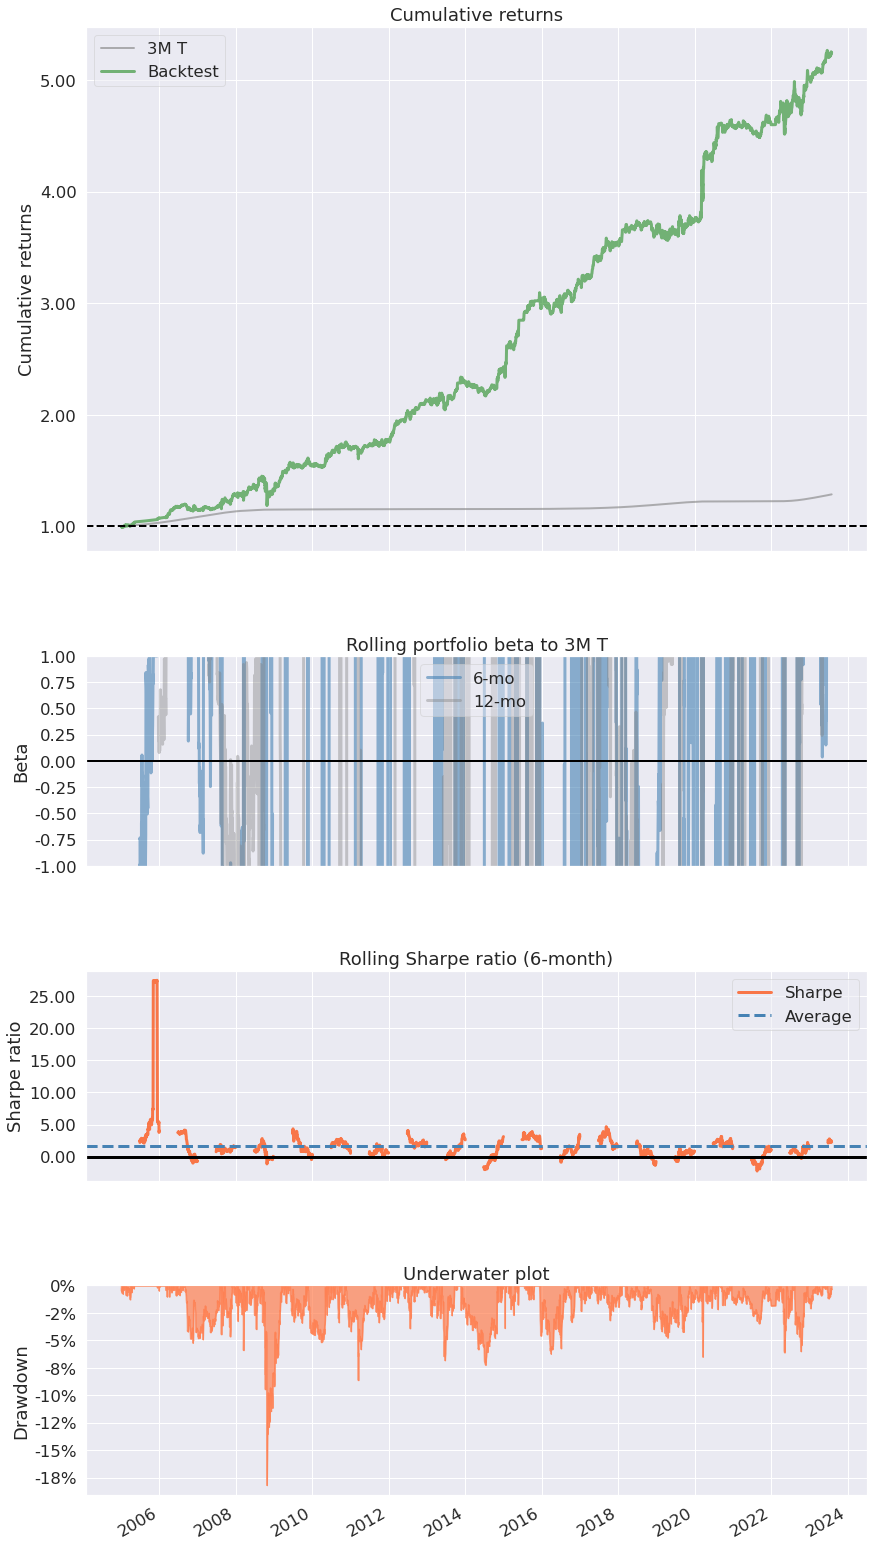

In [16]:
import pyfolio as pf
pf.create_simple_tear_sheet(performance, benchmark_rets=dfust.loc[performance.index].multiply(
    performance.index.to_series().diff().dt.days, axis='index').squeeze()/36000)

---comments here---